# Tutorial 9: Deep Autoencoders 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/AE_CIFAR10.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial9/AE_CIFAR10.ipynb)   
**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial9)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1acxmt1AK9iUvCLMNrd7qcI0WjJbQYxyv?usp=sharing)     
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/E2d8NRYt2e4)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/3UrX2mTY610)

In this tutorial, we will take a closer look at autoencoders (AE). Autoencoders are trained on encoding input data such as images into a smaller feature vector, and afterward, reconstruct it by a second neural network, called a decoder. The feature vector is called the "bottleneck" of the network as we aim to compress the input data into a smaller amount of features. This property is useful in many applications, in particular in compressing data or comparing images on a metric beyond pixel-level comparisons. Besides learning about the autoencoder framework, we will also see the "deconvolution" (or transposed convolution) operator in action for scaling up feature maps in height and width. Such deconvolution networks are necessary wherever we start from a small feature vector and need to output an image of full size (e.g. in VAE, GANs, or super-resolution applications). 

First of all, we again import most of our standard libraries. We will use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) to reduce the training code overhead.

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

# Load necessary Pytorch packages
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

/tmp/ipykernel_74881/3618881163.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Device: cuda:0


We have 4 pretrained models that we have to download. Remember the adjust the variables `DATASET_PATH` and `CHECKPOINT_PATH` if needed.

In this tutorial, we work with the CIFAR10 dataset. In CIFAR10, each image has 3 color channels and is 32x32 pixels large. As autoencoders do not have the constrain of modeling images probabilistic, we can work on more complex image data (i.e. 3 color channels instead of black-and-white) much easier than for VAEs. 
In case you have downloaded CIFAR10 already in a different directory, make sure to set DATASET_PATH accordingly to prevent another download.

In contrast to previous tutorials on CIFAR10 like [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) (CNN classification), we do not normalize the data explicitly with a mean of 0 and std of 1, but roughly estimate it scaling the data between -1 and 1. This is because limiting the range will make our task of predicting/reconstructing images easier.

In [3]:

#path = ('agb_XY_data.npz')
path = ('/home/ahexemer/Desktop/Inprinting/mixed_small_32x32.npz')   #read npz file with images
with np.load(path, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII') as data:
  train_dataset = data['x_train']
  ytrain_data = data['y_train']
  test_data = data['x_test']
  ytest_data= data['y_test']
stacked_img = np.stack((train_dataset,)*3, axis=3)
train_dataset = np.squeeze(stacked_img)
train_dataset = torch.tensor(train_dataset)
print(train_dataset.shape)
train_dataset = train_dataset.transpose(1,3)
print(train_dataset.shape)
train_set, val_set = torch.utils.data.random_split(train_dataset, [65000, 5000])


train_loader = torch.utils.data.DataLoader([ [train_set[i], train_set[i]] for i in range(65000)], shuffle=True,batch_size=30000, num_workers=24)
val_loader = torch.utils.data.DataLoader([ [val_set[i], val_set[i]] for i in range(5000)], batch_size=8000, num_workers=10)
test_loader = torch.utils.data.DataLoader([ [val_set[i], val_set[i]] for i in range(5000)], shuffle=True, batch_size=8000, num_workers=10)

''' # We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
 '''
def get_train_images(num):
    return torch.stack([train_dataset[i] for i in range(num)], dim=0)


torch.Size([70000, 32, 32, 3])
torch.Size([70000, 3, 32, 32])


## Building the autoencoder

In general, an autoencoder consists of an **encoder** that maps the input $x$ to a lower-dimensional feature vector $z$, and a **decoder** that reconstructs the input $\hat{x}$ from $z$. We train the model by comparing $x$ to $\hat{x}$ and optimizing the parameters to increase the similarity between $x$ and $\hat{x}$. See below for a small illustration of the autoencoder framework.

<center width="100%"><img src="autoencoder_visualization.svg" style="display: block; margin-left: auto; margin-right: auto;" width="650px"/></center>

We first start by implementing the encoder. The encoder effectively consists of a deep convolutional network, where we scale down the image layer-by-layer using strided convolutions. After downscaling the image three times, we flatten the features and apply linear layers. The latent representation $z$ is therefore a vector of size *d* which can be flexibly selected. 

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

Note that we do not apply Batch Normalization here. This is because we want the encoding of each image to be independent of all the other images. Otherwise, we might introduce correlations into the encoding or decoding that we do not want to have. In some implementations, you still can see Batch Normalization being used, because it can also serve as a form of regularization. Nevertheless, the better practice is to go with other normalization techniques if necessary like Instance Normalization or Layer Normalization. Given the small size of the model, we can neglect normalization for now.

The decoder is a mirrored, flipped version of the encoder. The only difference is that we replace strided convolutions by transposed convolutions (i.e. deconvolutions) to upscale the features. Transposed convolutions can be imagined as adding the stride to the input instead of the output, and can thus upscale the input. For an illustration of a `nn.ConvTranspose2d` layer with kernel size 3, stride 2, and padding 1, see below (figure credit - [Vincent Dumoulin and Francesco Visin](https://arxiv.org/abs/1603.07285)):

<center width="100%"><img src="deconvolution.gif" width="250px"></center>

You see that for an input of size $3\times3$, we obtain an output of $5\times5$. However, to truly have a reverse operation of the convolution, we need to ensure that the layer scales the input shape by a factor of 2 (e.g. $4\times4\to8\times8$). For this, we can specify the parameter `output_padding` which adds additional values to the output shape. Note that we do not perform zero-padding with this, but rather increase the output shape for calculation. 

Overall, the decoder can be implemented as follows:

In [9]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

The encoder and decoder networks we chose here are relatively simple. Usually, more complex networks are applied, especially when using a ResNet-based architecture. For example, see [VQ-VAE](https://arxiv.org/abs/1711.00937) and [NVAE](https://arxiv.org/abs/2007.03898) (although the papers discuss architectures for VAEs, they can equally be applied to standard autoencoders). 

In a final step, we add the encoder and decoder together into the autoencoder architecture. We define the autoencoder as PyTorch Lightning Module to simplify the needed training code:

In [10]:
class Autoencoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=20, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

### Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model. For this, we implement a callback object in PyTorch Lightning which will add reconstructions every $N$ epochs to our tensorboard:

In [11]:
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns both the test and validation score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU. Of course, feel free to train your own models on Lisa.

In [12]:
def train_cifar(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"), 
                         gpus=1 if str(device).startswith("cuda") else 0, 
                         max_epochs=150, 
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training

    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

### Comparing latent dimensionality

When training an autoencoder, we need to choose a dimensionality for the latent representation $z$. The higher the latent dimensionality, the better we expect the reconstruction to be. However, the idea of autoencoders is to *compress* data. Hence, we are also interested in keeping the dimensionality low. To find the best tradeoff, we can train multiple models with different latent dimensionalities. The original input has $32\times 32\times 3 = 3072$ pixels. Keeping this in mind, a reasonable choice for the latent dimensionality might be between 64 and 384:

In [13]:
model_dict = {}
for latent_dim in [256]:
    model_ld, result_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ahexemer/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 364 K  | [2, 3, 32, 32] | [2, 256]      
1 | decoder | Decoder | 365 K  | [2, 256]       | [2, 3, 32, 32]
----------------------------------------------------------------------
730 K     Trainable params
0         Non-trainable params
730 K     Total params
2.922     Total estimated model params size (MB)


/home/ahexemer/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/utils.py:53: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Global seed set to 42
/home/ahexemer/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 22:  25%|██▌       | 1/4 [00:02<00:08,  2.69s/it, loss=22.7, v_num=8]

After training the models, we can plot the reconstruction loss over the latent dimensionality to get an intuition how these two properties are correlated:

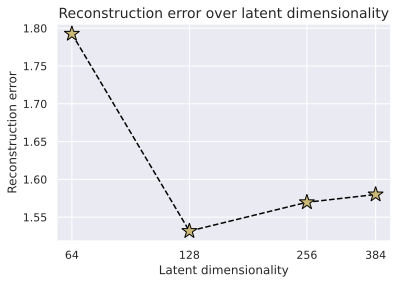

In [30]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
#plt.ylim(4,6)
plt.show()

## Finding visually similar images

One application of autoencoders is to build an image-based search engine to retrieve visually similar images. This can be done by representing all images as their latent dimensionality, and find the closest $K$ images in this domain. The first step to such a search engine is to encode all images into $z$. In the following, we will use the training set as a search corpus, and the test set as queries to the system.

<span style="color: #880000">(Warning: the following cells can be computationally heavy for a weak CPU-only system. If you do not have a strong computer and are not on Google Colab, you might want to skip the execution of the following cells and rely on the results shown in the filled notebook)</span>

In [20]:
# We use the following model throughout this section. 
# If you want to try a different latent dimensionality, change it here!
model = model_dict[256]["model"] 

In [21]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)


Encoding images:   0%|          | 0/3 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/1 [00:00<?, ?it/s]

After encoding all images, we just need to write a function that finds the closest $K$ images and returns (or plots) those:

In [33]:
def find_similar_images(query_img, query_z, key_embeds, K=12):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [31]:
torch.save(model, '.model')

ReferenceError: weakly-referenced object no longer exists

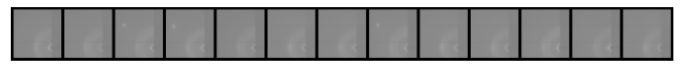

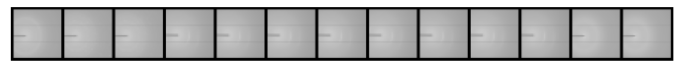

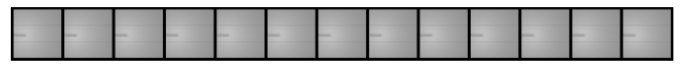

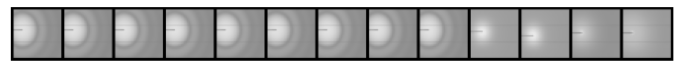

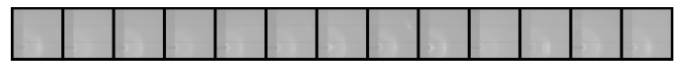

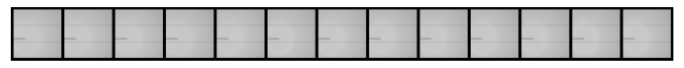

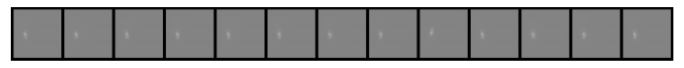

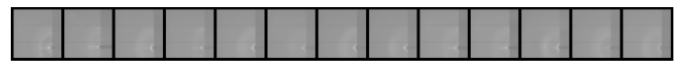

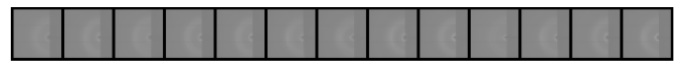

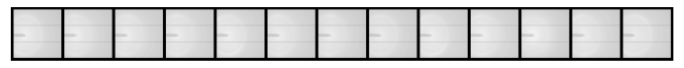

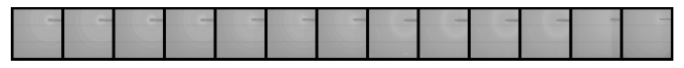

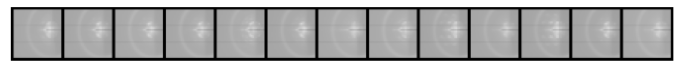

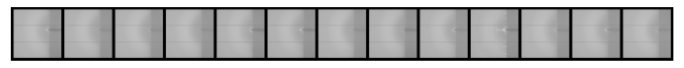

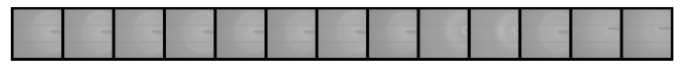

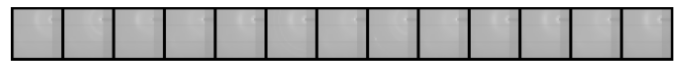

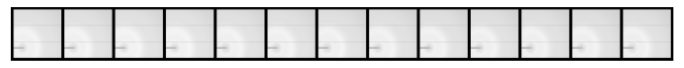

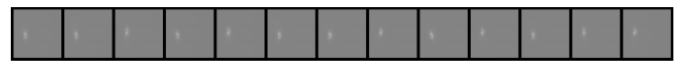

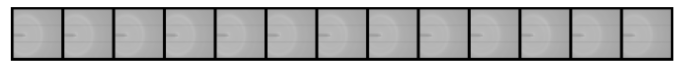

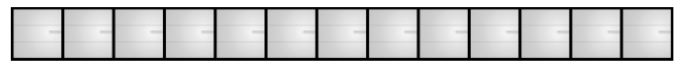

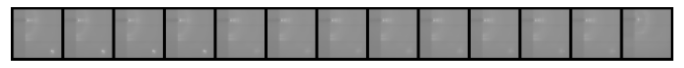

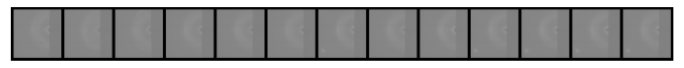

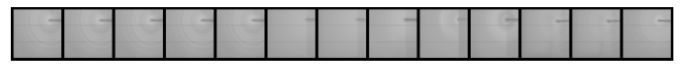

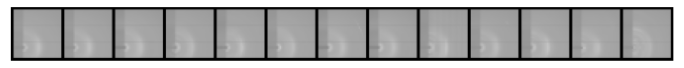

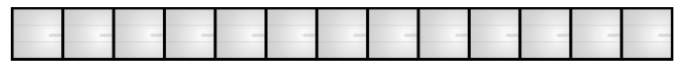

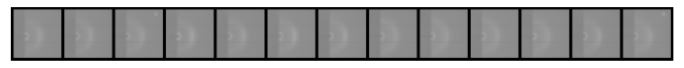

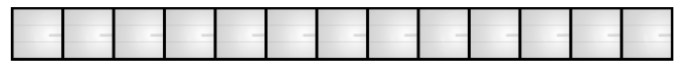

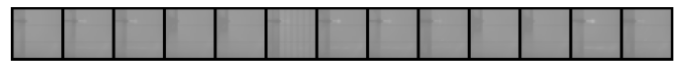

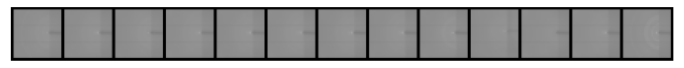

In [35]:
# Plot the closest images for the first N test images as example
for i in range(28):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)